<a href="https://colab.research.google.com/github/Dasyud/DynamicHandGest-GCN/blob/main/Dynamic_Gesture_Recognition_using_Graphs%2BResNet_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load your sample dataset by changing the directory location in the Entire dataset -> stellarGraphs section**

# Setting up the environment

In [ ]:
!pip install stellargraph
!pip install networkx

In [ ]:
# !pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# import tensorflow_addons as tfa
from keras.models import Model

from google.colab.patches import cv2_imshow
from sklearn import model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph
import networkx as nx

import glob
import pickle

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# ResNet50 CNN

In [ ]:
rows, cols, chnls = 100, 176, 3
# print(rows,cols,chnls)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model_pretrained = ResNet50(weights='imagenet',include_top = False,input_shape=(rows,cols,chnls))

model_pretrained.summary()

feature1dshape = model_pretrained.output_shape[1]*model_pretrained.output_shape[2]*model_pretrained.output_shape[3]
feature_vector = tf.reshape(model_pretrained.output,[-1,feature1dshape])
print(feature1dshape)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 182, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 88, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 88, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
feature_vector

<KerasTensor: shape=(None, 49152) dtype=float32 (created by layer 'tf.reshape')>

In [ ]:
bcnn_model = Model(inputs=model_pretrained.input, outputs=feature_vector)

# compile the model (should be done *after* setting layers to non-trainable)
# bcnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=numClasses)
# bcnn_model.summary()
# numClasses = 2
# one_hot_labels = tf.keras.utils.to_categorical(y_train, num_classes=numClasses)
# bcnn_model.fit(train_generator,epochs=10,batch_size=32)
# temp = bcnn_model.predict(X_train, y_train)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# type(X_train[0])
# len(X_train)
# len(one_hot_labels)
# one_hot_labels

In [ ]:
# len(X_train), len(X_train[0]), len(X_train[0][0])

In [ ]:
# len(y_train)

In [ ]:
# X_train[-1].shape

In [ ]:
# type((1, X_train[-1].shape))

In [ ]:
# prediction = bcnn_model.predict(np.reshape(X_train[-1], (1, *X_train[-1].shape)))
# prediction.shape

In [ ]:
# prediction

In [ ]:
# (prediction[10][8000])

In [ ]:
# model.predict()

# NetworkX + StellarGraph Demo

In [ ]:
n_nodes = 32
G = nx.path_graph(n_nodes)

In [ ]:
G.edges()

EdgeView([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31)])

In [ ]:
# prediction.flatten()

NameError: ignored

In [ ]:
nx.set_node_attributes(G, prediction.flatten(), name="features")
  # G.nodes(prediction[i])

In [ ]:
nx.get_node_attributes(G, "features")

In [ ]:
sg_graph = StellarGraph.from_networkx(G, node_features="features")

In [ ]:
print(sg_graph.info())

# Entire dataset -> StellarGraphs

In [ ]:
#Change dataset directory path here
#Directory should contain 2 folders, Swiping Up and Swiping Down
#These 2 folders should contain sub-folders where each sub-folder is numbered and contains all frames of 1 video
# Example
# dir = /content/drive/MyDrive/DIP/Group 10/Dataset/
#
#dir
#--->Swiping Up
#---|----->60
#---------|-->00001.jpg
#---------|-->....
#---------|-->00036.jpg
#---|----->....
#--->Swiping Down
#---|----->67
#---------|-->00001.jpg
#---------|-->....
#---------|-->00036.jpg
#---|----->....

dataset_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Dataset/'

In [ ]:
labels_list = []
list_of_graphs = []

In [ ]:
## This cell has been commented out since it is not involved in the demo, it is only used to quickly load already preprocessed data

# path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/'

# pickle_in = open(path + 'labels_list50.pickle', 'rb')
# labels_list = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open(path + 'graph_list50.pickle', 'rb')
# list_of_graphs = pickle.load(pickle_in)
# pickle_in.close()

In [ ]:
#Should be empty for demo, len = 0
len(list_of_graphs)

100

In [ ]:


folder_limit = 50
skip_folders = 200

# 0 -> for Swiping Up
# 1 -> for Swiping Down

#Swiping Up
f_cnt = 0
for folders in glob.glob(dataset_dir+'Swiping Up/*/'):
  fv_list = []
  img_cnt = 0
  print(f_cnt)
  if(f_cnt == folder_limit + skip_folders):
    break

  f_cnt += 1
  if(f_cnt <= skip_folders):
    continue
  for images in glob.glob(folders+'/*.*'):
    img_cnt += 1
    image = tf.keras.preprocessing.image.load_img(images, color_mode="rgb", target_size=(100, 176))
    image = np.array(image)
    fv_list.append(bcnn_model.predict(np.reshape(image, (1, *image.shape))).flatten())

  G = nx.path_graph(img_cnt)
  fv_dict = {k: v for k, v in enumerate(fv_list)}
  nx.set_node_attributes(G, fv_dict, name="features")

  sg_graph = StellarGraph.from_networkx(G, node_features="features")
  list_of_graphs.append(sg_graph)
  labels_list.append(0)

#Swiping Down
f_cnt = 0
for folders in glob.glob(dataset_dir+'Swiping Down/*/'):
  fv_list = []
  img_cnt = 0
  if(f_cnt == folder_limit+skip_folders):
    break

  f_cnt += 1
  if(f_cnt <= skip_folders):
    continue
  for images in glob.glob(folders+'/*.*'):
    img_cnt += 1
    image = tf.keras.preprocessing.image.load_img(images, color_mode="rgb", target_size=(100, 176))
    image = np.array(image)
    fv_list.append(bcnn_model.predict(np.reshape(image, (1, *image.shape))).flatten())

  G = nx.path_graph(img_cnt)
  fv_dict = {k: v for k, v in enumerate(fv_list)}
  nx.set_node_attributes(G, fv_dict, name="features")

  sg_graph = StellarGraph.from_networkx(G, node_features="features")
  list_of_graphs.append(sg_graph)
  labels_list.append(1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


In [ ]:
# fv_dict[1].shape

In [ ]:
print(list_of_graphs[-1].info())

StellarGraph: Undirected multigraph
 Nodes: 37, Edges: 36

 Node types:
  default: [37]
    Features: float32 vector, length 49152
    Edge types: default-default->default

 Edge types:
    default-default->default: [36]
        Weights: all 1 (default)
        Features: none


In [ ]:
## Commented out since this is not involved in demo

# path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/'

# pickle_out = open(path + 'labels_list50_skip200.pickle', 'wb')
# pickle.dump(labels_list, pickle_out)
# pickle_out.close()

# pickle_out = open(path + 'graph_list50_skip200.pickle', 'wb')
# pickle.dump(list_of_graphs, pickle_out)
# pickle_out.close()

In [ ]:
# nx.get_node_attributes(G, "features")

In [ ]:
# type(fv_dict[1])

# Training the model

In [ ]:
gen = PaddedGraphGenerator(graphs=list_of_graphs)

In [ ]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "relu", "relu", "tanh"],
    k=k,
    bias=False,
    generator=gen,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten, LeakyReLU

x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0005), loss=binary_crossentropy, metrics=["acc"],
)

In [ ]:
graph_labels = pd.DataFrame(labels_list, columns=['Labels'])
graph_labels['Labels'] = graph_labels['Labels'].astype('category')
graph_labels_encoded = graph_labels['Labels'].cat.codes

In [ ]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels_encoded, train_size=0.8, test_size=None, stratify=graph_labels_encoded,
)

In [ ]:
train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=8,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [ ]:
epochs = 50

In [ ]:
# !mkdir '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights'

mkdir: cannot create directory ‘/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights’: File exists


In [ ]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights/weights_epoch{epoch:02d}.ckpt',
#     save_weights_only=True,
#     verbose=1,
#     save_best_only=True,
#     monitor='val_loss')

In [ ]:
# Link to existing weights
# https://drive.google.com/drive/folders/1mt9uP0RI0tO8gXZBhZeFWYow_84qLTk9?usp=sharing
# Copy it to your drive and change directory name to load weights, else model will give poor results

model.load_weights('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights/')

In [ ]:
len(train_graphs)

80

In [ ]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True, callbacks=[cp_callback]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/sort_pooling_3/map/while/gradients/model_5/sort_pooling_3/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/sort_pooling_3/map/while/gradients/model_5/sort_pooling_3/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/sort_pooling_3/map/while/gradients/model_5/sort_pooling_3/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


10/10 [==============================] - ETA: 0s - loss: 0.8506 - acc: 0.8375
Epoch 1: val_loss improved from inf to 0.38043, saving model to /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights/weights_epoch01.ckpt
10/10 [==============================] - 5s 308ms/step - loss: 0.8506 - acc: 0.8375 - val_loss: 0.3804 - val_acc: 0.8500
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.4318 - acc: 0.8375
Epoch 2: val_loss improved from 0.38043 to 0.26490, saving model to /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights/weights_epoch02.ckpt
10/10 [==============================] - 2s 239ms/step - loss: 0.4318 - acc: 0.8375 - val_loss: 0.2649 - val_acc: 0.9000
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.3356 - acc: 0.8875
Epoch 3: val_loss improved from 0.26490 to 0.19043, saving model to /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights/weights_epoch03.ckpt
10/10 [=======

In [ ]:
model.save_weights('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/weights/')

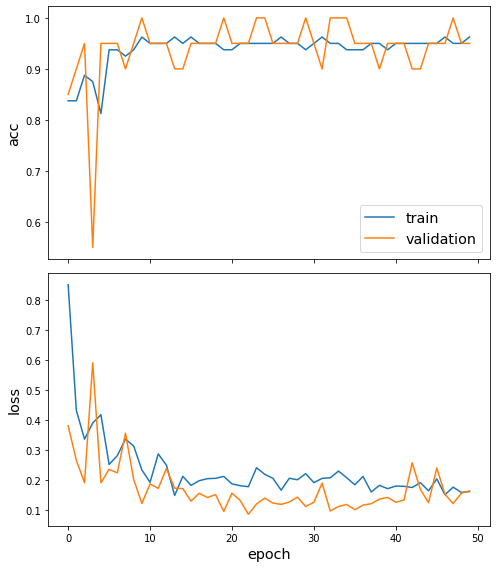

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

20/20 [==============================] - 1s 26ms/step - loss: 0.1632 - acc: 0.9500

Test Set Metrics:
	loss: 0.1632
	acc: 0.9500
